In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from sqlalchemy import text

plt.style.use("ggplot")

# Task 2.15: Testing, documentation and reporting

## Part H: Vikedal


In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


In [4]:
# Read data
xl_path = r"../../data/vikedal_data.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="station")
wc_df = pd.read_excel(xl_path, sheet_name="chem", decimal=",")
wc_df["date"] = pd.to_datetime(wc_df["date"])

print("Water chemsitry data:")
display(wc_df.head())

print("Station details:")
display(stn_df)

Water chemsitry data:


,site_id,parameter,date,value
0,038-44506,N-NO3,2011-08-01,80.0
1,038-44506,P-TOT,2011-11-07,2.0
2,038-44506,P-TOT,2011-12-05,1.0
3,038-44506,N-NO3,2011-11-07,105.0
4,038-44506,N-NO3,2011-12-05,195.0


Station details:


,site_id,site_name,utm33_e,utm33_n,nve_station_id
0,038-44506,Vikedalselva oppstrøms Låkafossen (VK9),-9249.65,6.634374e+06,38.1.0


In [5]:
# Restructure
wc_df = wc_df.groupby(["site_id", "parameter", "date"]).mean()
wc_df = wc_df.unstack("parameter")
wc_df.columns = [f"{col}_ug/l" for col in wc_df.columns.get_level_values(1)]
wc_df.reset_index(inplace=True)

# wc_df["DIN_ug/l"] = wc_df["N-NH4_ug/l"] + wc_df["N-NO3_ug/l"]
# wc_df["TON_ug/l"] = wc_df["N-TOT_ug/l"] - wc_df["DIN_ug/l"]
wc_df.rename(columns={"N-TOT_ug/l": "TOTN_ug/l", "P-TOT_ug/l": "TOTP_ug/l"}, inplace=True)
del wc_df["N-NH4_ug/l"], wc_df["N-NO3_ug/l"]

wc_df.dropna(how='any', inplace=True)
wc_df

,site_id,date,TOTN_ug/l,TOTP_ug/l
230,038-44506,1998-01-30,205.0,1.0
231,038-44506,1998-02-15,210.0,2.0
232,038-44506,1998-03-03,215.0,2.0
233,038-44506,1998-03-15,215.0,1.0
234,038-44506,1998-04-01,235.0,2.0
...,...,...,...,...
512,038-44506,2022-08-08,190.0,2.0
513,038-44506,2022-09-05,150.0,2.1
514,038-44506,2022-10-03,150.0,4.0
515,038-44506,2022-10-31,210.0,2.0


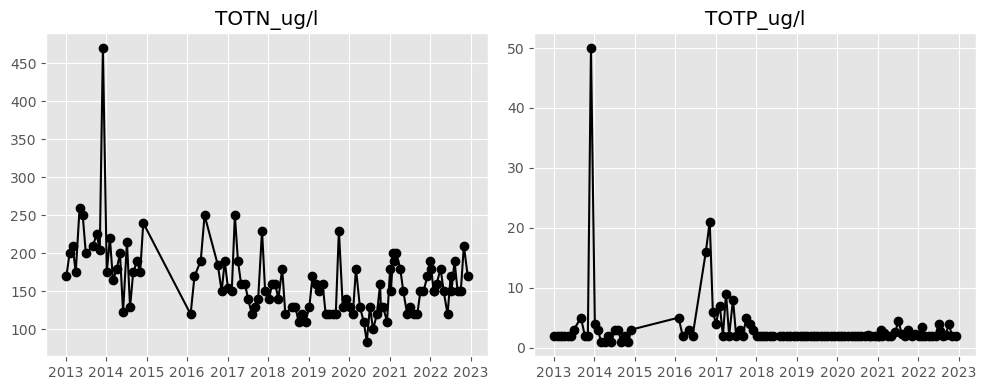

In [6]:
wc_df = wc_df.query("date >= '2013-01-01'")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pars = ['TOTN_ug/l', 'TOTP_ug/l']
for idx, par in enumerate(pars):
    par_df = wc_df[['date', par]].copy()
    par_df.sort_values("date", inplace=True)
    axes[idx].plot(par_df["date"], par_df[par], "ko-")
    axes[idx].set_title(par)
plt.tight_layout()

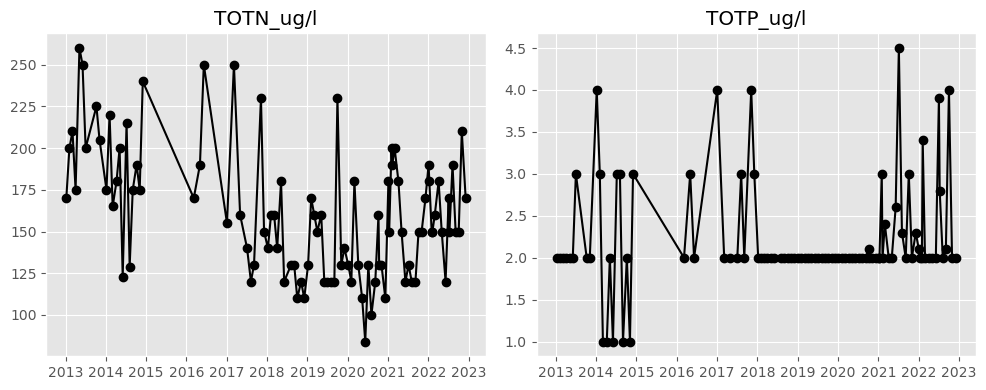

In [7]:
# Remove extreme values
wc_df = wc_df[(wc_df['TOTN_ug/l'] < 300) & (wc_df['TOTP_ug/l'] < 5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for idx, par in enumerate(pars):
    par_df = wc_df[['date', par]].copy()
    par_df.sort_values("date", inplace=True)
    axes[idx].plot(par_df["date"], par_df[par], "ko-")
    axes[idx].set_title(par)
plt.tight_layout()

In [8]:
nve_stn_df = nivapy.da.get_nve_hydapi_stations()
nve_stn_df = nve_stn_df.query("station_id == '38.1.0'")
nve_stn_df

,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
1289,38.1.0,Holmen,59.49883,5.91306,-13443,6630792,15,Vikadalselva,1160,Vindafjord,...,147.0065,167.4434,187.94,215.8337,3.7007,3.9377,4.1349,4.3194,4.5529,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [9]:
# Derive catchment boundaries for chem and Q stations
stn_gdf = nivapy.spatial.derive_watershed_boundaries(
    stn_df,
    id_col="site_id",
    xcol="utm33_e",
    ycol="utm33_n",
    crs="epsg:25833",
    min_size_km2=5,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
stn_gdf["chem_area_km2"] = stn_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6

nve_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=5,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
nve_gdf["q_area_km2"] = nve_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6
nve_gdf["nve_station_id"] = nve_gdf["station_id"]

# Join areas back to 'stn_df' and compare to NVE values for the Q stations (from HydAPI)
stn_df = pd.merge(
    stn_df,
    stn_gdf[["site_id", "chem_area_km2"]],
    how="left",
    on="site_id",
)
stn_df = pd.merge(
    stn_df,
    nve_gdf[["nve_station_id", "q_area_km2"]],
    how="left",
    on="nve_station_id",
)

stn_df

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 038:   0%|          | 0/1 [00:00<?, ?it/s]

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 038:   0%|          | 0/1 [00:00<?, ?it/s]

,site_id,site_name,utm33_e,utm33_n,nve_station_id,chem_area_km2,q_area_km2
0,038-44506,Vikedalselva oppstrøms Låkafossen (VK9),-9249.65,6.634374e+06,38.1.0,87.817875,115.91932


In [10]:
# Estimate annual fluxes
df_list = []
par_list = ['TOTN_ug/l', 'TOTP_ug/l']
for idx, row in stn_df.iterrows():
    vm_id = row["site_id"]
    nve_id = row["nve_station_id"]
    area_fac = row["chem_area_km2"] / row["q_area_km2"]

    # Get chem data for station
    chem_stn_df = wc_df.query("site_id == @vm_id").copy()
    chem_stn_df.set_index("date", inplace=True)
    chem_stn_df = chem_stn_df[par_list].resample("D").mean().dropna()

    # Get flow data for stations
    q_stn_df = nivapy.da.query_nve_hydapi(
        [nve_id], [1001], f"2013-01-01", f"2022-12-31", resolution=1440
    )
    q_stn_df = area_fac * q_stn_df.set_index("datetime")[["value"]].resample("D").mean()
    q_stn_df.index = q_stn_df.index.tz_localize(None)
    q_stn_df.rename(columns={"value": "flow_m3/s"}, inplace=True)

    # Calculate annual fluxes
    flux_df = nivapy.stats.estimate_fluxes(
        q_stn_df,
        chem_stn_df,
        base_freq="D",
        agg_freq="A",
        method="ospar_annual",
    )

    # Convert kg to tonnes
    flux_df = flux_df / 1000
    flux_df.columns = [col.replace("kg", "tonnes") for col in flux_df.columns]
    flux_df["site_id"] = vm_id
    df_list.append(flux_df)
flux_df = pd.concat(df_list, axis="rows")
flux_df = flux_df.reset_index()

flux_df

,year,TOTN_tonnes,TOTP_tonnes,site_id
0,2013,61.100798,0.585371,038-44506
1,2014,51.165913,0.513404,038-44506
2,2015,NaN,NaN,038-44506
3,2016,66.489886,0.611333,038-44506
4,2017,63.922732,1.218751,038-44506
5,2018,36.699365,0.562337,038-44506
6,2019,35.739390,0.517659,038-44506
7,2020,47.451872,0.758123,038-44506
8,2021,34.840626,0.544626,038-44506
9,2022,45.652146,0.669580,038-44506


In [11]:
nve_data_year = 2023
st_yr, end_yr = 2013, 2022
out_csv_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [12]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text
    
# Read saved data for speed
mod_csv = os.path.join(
    eval_fold, f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"
)
mod_df = pd.read_csv(mod_csv)
   
# Tidy modelled data for comparison
cols = [col for col in mod_df.columns if col.startswith("accum_")]
mod_df = mod_df[["regine", "year"] + cols].copy()
cols = [remove_prefix(col, "accum_") for col in cols]
mod_df.columns = ["regine", "year"] + cols
for col in cols:
    if col.endswith("_kg"):
        mod_df[col[:-3] + "_tonnes"] = mod_df[col] / 1000
    del mod_df[col]

regines = ['038.AZ', '038.B']
mod_df = mod_df.query("regine in @regines").groupby('year').sum(numeric_only=True).reset_index()
mod_df.head()

,year,agriculture-background_din_tonnes,agriculture-background_ss_tonnes,agriculture-background_tdp_tonnes,agriculture-background_toc_tonnes,agriculture-background_ton_tonnes,agriculture-background_totn_tonnes,agriculture-background_totp_tonnes,agriculture-background_tpp_tonnes,agriculture_din_tonnes,...,urban_totp_tonnes,urban_tpp_tonnes,wood_din_tonnes,wood_ss_tonnes,wood_tdp_tonnes,wood_toc_tonnes,wood_ton_tonnes,wood_totn_tonnes,wood_totp_tonnes,wood_tpp_tonnes
0,2013,0.664558,1.122448,0.005704,5.017726,0.271473,0.936031,0.010786,0.005081,7.002569,...,0.005129,0.001003,4.620745,1.309979,0.084019,158.021706,8.218219,12.838964,0.114529,0.030510
1,2014,0.671259,1.126489,0.005704,5.017726,0.278592,0.949852,0.010786,0.005081,7.567104,...,0.005457,0.001068,4.882257,1.309979,0.088684,166.966389,8.683378,13.565635,0.120948,0.032264
2,2015,0.711052,1.148548,0.005704,5.017726,0.320868,1.031921,0.010786,0.005081,9.244882,...,0.007217,0.001424,6.432753,1.309979,0.116886,219.990406,11.440925,17.873678,0.159352,0.042466
3,2016,0.666561,1.123667,0.005704,5.017726,0.273601,0.940163,0.010786,0.005081,7.042820,...,0.005249,0.001036,4.698986,1.309979,0.085407,160.696907,8.357191,13.056177,0.116488,0.031081
4,2017,0.707630,1.146758,0.005704,5.017726,0.317232,1.024862,0.010786,0.005081,9.154119,...,0.007009,0.001392,6.299388,1.309979,0.114507,215.428892,11.203885,17.503273,0.156140,0.041633


In [13]:
# Merge
comp_df = pd.merge(flux_df, mod_df, how="left", on="year")
comp_df.head()

,year,TOTN_tonnes,TOTP_tonnes,site_id,agriculture-background_din_tonnes,agriculture-background_ss_tonnes,agriculture-background_tdp_tonnes,agriculture-background_toc_tonnes,agriculture-background_ton_tonnes,agriculture-background_totn_tonnes,...,urban_totp_tonnes,urban_tpp_tonnes,wood_din_tonnes,wood_ss_tonnes,wood_tdp_tonnes,wood_toc_tonnes,wood_ton_tonnes,wood_totn_tonnes,wood_totp_tonnes,wood_tpp_tonnes
0,2013,61.100798,0.585371,038-44506,0.664558,1.122448,0.005704,5.017726,0.271473,0.936031,...,0.005129,0.001003,4.620745,1.309979,0.084019,158.021706,8.218219,12.838964,0.114529,0.030510
1,2014,51.165913,0.513404,038-44506,0.671259,1.126489,0.005704,5.017726,0.278592,0.949852,...,0.005457,0.001068,4.882257,1.309979,0.088684,166.966389,8.683378,13.565635,0.120948,0.032264
2,2015,NaN,NaN,038-44506,0.711052,1.148548,0.005704,5.017726,0.320868,1.031921,...,0.007217,0.001424,6.432753,1.309979,0.116886,219.990406,11.440925,17.873678,0.159352,0.042466
3,2016,66.489886,0.611333,038-44506,0.666561,1.123667,0.005704,5.017726,0.273601,0.940163,...,0.005249,0.001036,4.698986,1.309979,0.085407,160.696907,8.357191,13.056177,0.116488,0.031081
4,2017,63.922732,1.218751,038-44506,0.707630,1.146758,0.005704,5.017726,0.317232,1.024862,...,0.007009,0.001392,6.299388,1.309979,0.114507,215.428892,11.203885,17.503273,0.156140,0.041633


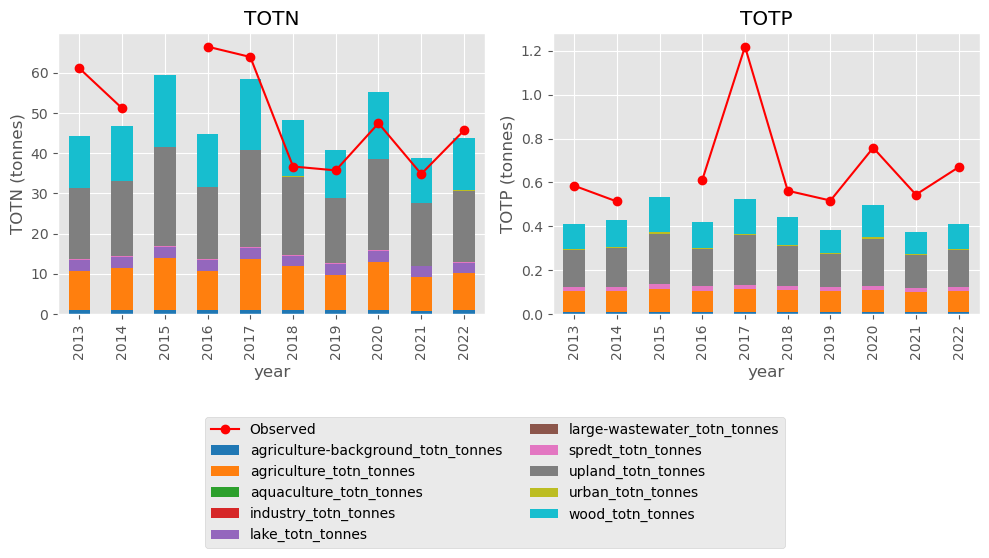

In [14]:
# Plot: single parameter per river
pars = ["TOTN", "TOTP"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

for idx, par in enumerate(pars):
    par_cols = [
        col
        for col in comp_df.columns
        if par.lower() in (i.lower() for i in col.split("_"))
    ]

    comp_par_df = comp_df.set_index("year")[par_cols]

    comp_par_df.drop(columns=[f"{par}_tonnes"]).plot(
        kind="bar",
        stacked=True,
        ax=axes[idx],
        legend=False,
        cmap="tab10",
    )

    axes[idx].plot(
        comp_par_df.index - comp_par_df.index.min(),
        comp_par_df[f"{par}_tonnes"],
        marker="o",
        color="red",
        label="Observed",
    )
    axes[idx].set_title(par)
    axes[idx].set_ylabel(f"{par} (tonnes)")
plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=2)